In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import tensorflow as tf

from src.loaders.data_loader import load_train_data, load_basic_preprocessed_train
from src.preprocessors.preprocessors import split_train_valid_test

from src.model.multiple_output.convolution import Convolution2DVarious
from src.loaders.data_loader import load_test_features, load_basic_preprocessed_predict, load_submission_data
from src.loaders.window_generator import WindowGenerator
from src.trainers import compile_and_fit_with_pinball_loss

df = load_train_data()
np.random.seed(42)
tf.random.set_seed(42)

In [2]:
df.head(5)

,Day,Hour,Minute,DHI,DNI,WS,RH,T,TARGET
0,0,0,0,0,0,1.5,69.08,-12,0.0
1,0,0,30,0,0,1.5,69.06,-12,0.0
2,0,1,0,0,0,1.6,71.78,-12,0.0
3,0,1,30,0,0,1.6,71.75,-12,0.0
4,0,2,0,0,0,1.6,75.20,-12,0.0


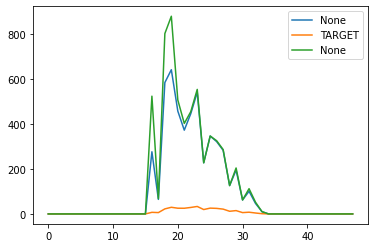

In [3]:
import matplotlib.pyplot as plt

(df["DHI"] + df["DNI"] * -np.cos(df["Hour"] * (2 * np.pi) / 24))[0:48].plot()
df["TARGET"][0:48].plot()
(df["DHI"] + df["DNI"])[0:48].plot()
plt.legend()

In [4]:
train_df, valid_df, test_df = split_train_valid_test(df, [0.7, 0.2, 0.1])

train_df_target = train_df["TARGET"]
valid_df_target = valid_df["TARGET"]
test_df_target = test_df["TARGET"]

train_df, valid_df, test_df = load_basic_preprocessed_train("minmax")

train_df["scaled_TARGET"] = train_df["TARGET"]
valid_df["scaled_TARGET"] = valid_df["TARGET"]
test_df["scaled_TARGET"] = test_df["TARGET"]

train_df["TARGET"] = train_df_target
valid_df["TARGET"] = valid_df_target
test_df["TARGET"] = test_df_target

train_df.describe()

ratio should be 3 length list, example: [0.6, 0.3, 0.1]
sum of ration should be 1, example: [0.7, 0.2, 0.1]
shape of train, valid, test: (36792, 9), (10511, 9), (5257, 9)
ratio should be 3 length list, example: [0.6, 0.3, 0.1]
sum of ration should be 1, example: [0.7, 0.2, 0.1]
shape of train, valid, test: (36792, 16), (10511, 16), (5257, 16)


,DHI,DNI,WS,RH,T,TARGET,Day_sin,Day_cos,Hour_sin,Hour_cos,GHI,TARGET_ROLLING_MEAN_3_shift_1,TARGET_ROLLING_MEAN_5_shift_2,TARGET_ROLLING_MEAN_11_shift_5,TARGET_ROLLING_MEAN_23_shift_11,TARGET_ROLLING_MEAN_47_shift_23,scaled_TARGET
count,36792.000000,36792.000000,36792.000000,36792.000000,36792.000000,36792.000000,36792.000000,36792.000000,36792.000000,36792.000000,36792.000000,3.679200e+04,36792.000000,3.679200e+04,36792.000000,36792.000000,36792.000000
mean,0.119412,0.219731,0.201327,0.542351,0.512100,17.439978,0.507046,0.522326,0.500206,0.500027,0.267026,1.754282e-01,0.177078,1.873781e-01,0.239824,0.469365,0.174550
std,0.194232,0.330292,0.117052,0.234989,0.192822,25.449577,0.346981,0.359263,0.353558,0.353558,0.263381,2.493108e-01,0.245816,2.357651e-01,0.221283,0.211497,0.254715
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.116667,0.364896,0.351852,0.000000,0.159610,0.158025,0.146447,0.146447,0.088432,3.356260e-15,0.000000,1.852145e-16,0.044158,0.297058,0.000000
50%,0.000000,0.000000,0.183333,0.553620,0.500000,0.000000,0.530107,0.536539,0.500000,0.500000,0.088432,1.006823e-02,0.023250,7.214131e-02,0.186432,0.447393,0.000000
75%,0.160985,0.430831,0.258333,0.711963,0.648148,31.085053,0.840390,0.891488,0.853553,0.853553,0.415900,3.152806e-01,0.319378,3.256305e-01,0.378664,0.634329,0.311118
max,1.000000,1.000000,1.000000,1.000000,1.000000,99.913939,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000e+00,1.000000,1.000000e+00,1.000000,1.000000,1.000000


In [5]:
cutter = [
    'DHI', 
    'DNI', 
#     'WS', 
#     'RH', 
#     'T', 
#     'Hour_sin',
#     'Hour_cos', 
    'GHI', 
#     'TARGET_ROLLING_MEAN_3_shift_1',
#     'TARGET_ROLLING_MEAN_5_shift_2', 
#     'TARGET_ROLLING_MEAN_11_shift_5',
#     'TARGET_ROLLING_MEAN_23_shift_11', 
#     'TARGET_ROLLING_MEAN_47_shift_23',
    'scaled_TARGET',
    "TARGET",
]
train_df = train_df[cutter]
valid_df = valid_df[cutter]
test_df = test_df[cutter]

In [6]:
one_days_window_label_columns = WindowGenerator(
    train_df,
    valid_df,
    test_df,
    input_width=48 * 5,
    label_width=96,
    shift=96,
    sequence_stride=1,
    label_columns=["TARGET"]
    
)
one_days_window_label_columns


            Total window size: 336
            Input indices: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 

In [7]:
import src.model.multiple_output.convolution
import importlib
importlib.reload(src.model.multiple_output.convolution)


days = 7

one_days_window_label_columns = WindowGenerator(
    train_df,
    valid_df,
    test_df,
    input_width=48 * days,
    label_width=96,
    shift=96,
    sequence_stride=1,
    label_columns=["TARGET"]
    
)
submission_df = load_submission_data()
_, predict_df = load_basic_preprocessed_predict("minmax")
predict_df["scaled_TARGET"] = predict_df["TARGET"]
predict_df = predict_df[cutter]
predict_df.drop("TARGET", axis=1, inplace=True)
predict_df = load_test_features(predict_df, 48 * days)

evaluate_dict = {}

for i in range(1, 10):
    q = i/10
    print(q)
    
    conv_various = Convolution2DVarious(days, 96, train_df.shape[-1] - 1)

    compile_and_fit_with_pinball_loss(conv_various, one_days_window_label_columns, q)
    evaluate_dict[q] = conv_various.evaluate(one_days_window_label_columns.test, verbose=0)
    predict_np = predict_df.reshape(-1, days, 48, train_df.shape[-1] - 1)
    pred_y = conv_various.predict(predict_np)[:, :, -1]
    submission_df[f"q_{q}"] = pred_y.reshape(-1)


ratio should be 3 length list, example: [0.6, 0.3, 0.1]
sum of ration should be 1, example: [0.7, 0.2, 0.1]
shape of train, valid, test: (36792, 16), (10511, 16), (5257, 16)
0.1
Epoch 1/1000
1137/1137 [==============================] - 27s 15ms/step - loss: 1.6232 - mean_absolute_error: 15.3887 - mean_squared_error: 756.7950 - _pinball_loss: 1.6232 - val_loss: 1.8743 - val_mean_absolute_error: 16.6931 - val_mean_squared_error: 784.1779 - val__pinball_loss: 1.8743
Epoch 2/1000
1137/1137 [==============================] - 9s 8ms/step - loss: 1.4617 - mean_absolute_error: 12.8708 - mean_squared_error: 538.5213 - _pinball_loss: 1.4617 - val_loss: 1.8323 - val_mean_absolute_error: 15.8554 - val_mean_squared_error: 712.3745 - val__pinball_loss: 1.8323
Epoch 3/1000
1137/1137 [==============================] - 9s 8ms/step - loss: 1.4287 - mean_absolute_error: 12.3571 - mean_squared_error: 498.7604 - _pinball_loss: 1.4287 - val_loss: 1.8166 - val_mean_absolute_error: 15.5750 - val_mean_squared_

0.2
Epoch 1/1000
1137/1137 [==============================] - 10s 8ms/step - loss: 2.9931 - mean_absolute_error: 13.6716 - mean_squared_error: 622.8927 - _pinball_loss: 2.9931 - val_loss: 3.1828 - val_mean_absolute_error: 13.1840 - val_mean_squared_error: 508.1332 - val__pinball_loss: 3.1828
Epoch 2/1000
1137/1137 [==============================] - 9s 8ms/step - loss: 2.4908 - mean_absolute_error: 10.1198 - mean_squared_error: 347.4274 - _pinball_loss: 2.4908 - val_loss: 3.0886 - val_mean_absolute_error: 12.4211 - val_mean_squared_error: 453.6729 - val__pinball_loss: 3.0886
Epoch 3/1000
1137/1137 [==============================] - 9s 8ms/step - loss: 2.4124 - mean_absolute_error: 9.5818 - mean_squared_error: 311.6272 - _pinball_loss: 2.4124 - val_loss: 3.0385 - val_mean_absolute_error: 12.0010 - val_mean_squared_error: 425.3909 - val__pinball_loss: 3.0385
Epoch 4/1000
1137/1137 [==============================] - 9s 8ms/step - loss: 2.3656 - mean_absolute_error: 9.2774 - mean_squared_er

1137/1137 [==============================] - 9s 8ms/step - loss: 2.6378 - mean_absolute_error: 6.4874 - mean_squared_error: 152.6186 - _pinball_loss: 2.6378 - val_loss: 3.4402 - val_mean_absolute_error: 8.4598 - val_mean_squared_error: 230.0593 - val__pinball_loss: 3.4402
Epoch 10/1000
1137/1137 [==============================] - 9s 8ms/step - loss: 2.6324 - mean_absolute_error: 6.4631 - mean_squared_error: 151.8536 - _pinball_loss: 2.6324 - val_loss: 3.4493 - val_mean_absolute_error: 8.4160 - val_mean_squared_error: 228.7889 - val__pinball_loss: 3.4493
Epoch 11/1000
1137/1137 [==============================] - 9s 8ms/step - loss: 2.6235 - mean_absolute_error: 6.4401 - mean_squared_error: 151.1213 - _pinball_loss: 2.6235 - val_loss: 3.4433 - val_mean_absolute_error: 8.4844 - val_mean_squared_error: 231.3889 - val__pinball_loss: 3.4433
Epoch 12/1000
1137/1137 [==============================] - 9s 8ms/step - loss: 2.6142 - mean_absolute_error: 6.4042 - mean_squared_error: 149.9249 - _pin

1137/1137 [==============================] - 10s 9ms/step - loss: 2.6897 - mean_absolute_error: 5.4287 - mean_squared_error: 121.7725 - _pinball_loss: 2.6897 - val_loss: 3.5886 - val_mean_absolute_error: 7.3294 - val_mean_squared_error: 190.6151 - val__pinball_loss: 3.5886
0.5
Epoch 1/1000
1137/1137 [==============================] - 10s 9ms/step - loss: 4.6211 - mean_absolute_error: 9.2423 - mean_squared_error: 305.1378 - _pinball_loss: 4.6211 - val_loss: 3.6813 - val_mean_absolute_error: 7.3626 - val_mean_squared_error: 204.1061 - val__pinball_loss: 3.6813
Epoch 2/1000
1137/1137 [==============================] - 10s 9ms/step - loss: 2.8850 - mean_absolute_error: 5.7700 - mean_squared_error: 141.2110 - _pinball_loss: 2.8850 - val_loss: 3.5710 - val_mean_absolute_error: 7.1420 - val_mean_squared_error: 201.4057 - val__pinball_loss: 3.5710
Epoch 3/1000
1137/1137 [==============================] - 10s 9ms/step - loss: 2.8025 - mean_absolute_error: 5.6050 - mean_squared_error: 138.1289 -

Epoch 12/1000
1137/1137 [==============================] - 10s 9ms/step - loss: 2.3826 - mean_absolute_error: 5.4386 - mean_squared_error: 153.0287 - _pinball_loss: 2.3826 - val_loss: 3.0900 - val_mean_absolute_error: 6.9547 - val_mean_squared_error: 218.8538 - val__pinball_loss: 3.0900
Epoch 13/1000
1137/1137 [==============================] - 11s 10ms/step - loss: 2.3703 - mean_absolute_error: 5.4140 - mean_squared_error: 152.4644 - _pinball_loss: 2.3703 - val_loss: 3.0965 - val_mean_absolute_error: 7.0490 - val_mean_squared_error: 226.0508 - val__pinball_loss: 3.0965
Epoch 14/1000
1137/1137 [==============================] - 11s 10ms/step - loss: 2.3682 - mean_absolute_error: 5.4119 - mean_squared_error: 152.5097 - _pinball_loss: 2.3682 - val_loss: 3.0759 - val_mean_absolute_error: 6.9573 - val_mean_squared_error: 221.7318 - val__pinball_loss: 3.0759
Epoch 15/1000
1137/1137 [==============================] - 12s 11ms/step - loss: 2.3584 - mean_absolute_error: 5.3912 - mean_squared_e

1137/1137 [==============================] - 11s 9ms/step - loss: 4.2972 - mean_absolute_error: 13.0073 - mean_squared_error: 415.9955 - _pinball_loss: 4.2972 - val_loss: 2.1780 - val_mean_absolute_error: 9.2142 - val_mean_squared_error: 326.9999 - val__pinball_loss: 2.1780
Epoch 2/1000
1137/1137 [==============================] - 11s 9ms/step - loss: 1.7377 - mean_absolute_error: 7.3063 - mean_squared_error: 223.2360 - _pinball_loss: 1.7377 - val_loss: 2.0886 - val_mean_absolute_error: 8.6988 - val_mean_squared_error: 314.0332 - val__pinball_loss: 2.0886
Epoch 3/1000
1137/1137 [==============================] - 11s 9ms/step - loss: 1.6388 - mean_absolute_error: 6.9660 - mean_squared_error: 218.1192 - _pinball_loss: 1.6388 - val_loss: 2.0116 - val_mean_absolute_error: 8.3140 - val_mean_squared_error: 302.8333 - val__pinball_loss: 2.0116
Epoch 4/1000
1137/1137 [==============================] - 11s 9ms/step - loss: 1.5843 - mean_absolute_error: 6.7799 - mean_squared_error: 214.8402 - _p

1137/1137 [==============================] - 11s 10ms/step - loss: 1.3251 - mean_absolute_error: 5.9739 - mean_squared_error: 197.5930 - _pinball_loss: 1.3251 - val_loss: 1.8353 - val_mean_absolute_error: 7.7435 - val_mean_squared_error: 290.3958 - val__pinball_loss: 1.8353
Epoch 30/1000
1137/1137 [==============================] - 11s 10ms/step - loss: 1.3229 - mean_absolute_error: 5.9644 - mean_squared_error: 197.0519 - _pinball_loss: 1.3229 - val_loss: 1.8452 - val_mean_absolute_error: 8.2547 - val_mean_squared_error: 315.3579 - val__pinball_loss: 1.8452
0.9
Epoch 1/1000
1137/1137 [==============================] - 12s 10ms/step - loss: 3.9054 - mean_absolute_error: 19.3561 - mean_squared_error: 762.4905 - _pinball_loss: 3.9054 - val_loss: 1.3846 - val_mean_absolute_error: 11.1609 - val_mean_squared_error: 398.9000 - val__pinball_loss: 1.3846
Epoch 2/1000
1137/1137 [==============================] - 11s 10ms/step - loss: 1.1085 - mean_absolute_error: 9.3806 - mean_squared_error: 284

Epoch 25/1000
1137/1137 [==============================] - 11s 10ms/step - loss: 0.7880 - mean_absolute_error: 7.1121 - mean_squared_error: 236.9266 - _pinball_loss: 0.7880 - val_loss: 1.0560 - val_mean_absolute_error: 8.7284 - val_mean_squared_error: 331.8808 - val__pinball_loss: 1.0560
Epoch 26/1000
1137/1137 [==============================] - 11s 10ms/step - loss: 0.7837 - mean_absolute_error: 7.0824 - mean_squared_error: 236.1302 - _pinball_loss: 0.7837 - val_loss: 1.0501 - val_mean_absolute_error: 8.9753 - val_mean_squared_error: 341.0547 - val__pinball_loss: 1.0501
Epoch 27/1000
1137/1137 [==============================] - 11s 10ms/step - loss: 0.7797 - mean_absolute_error: 7.0597 - mean_squared_error: 235.4641 - _pinball_loss: 0.7797 - val_loss: 1.0513 - val_mean_absolute_error: 8.9891 - val_mean_squared_error: 347.2086 - val__pinball_loss: 1.0513
Epoch 28/1000
1137/1137 [==============================] - 11s 10ms/step - loss: 0.7768 - mean_absolute_error: 7.0392 - mean_squared_

In [8]:
evaluate_dict

{0.1: [0.9796475768089294,
  7.050142288208008,
  181.86700439453125,
  0.9796915650367737],
 0.2: [1.5727002620697021,
  5.466338634490967,
  110.00485229492188,
  1.5729024410247803],
 0.3: [1.845992922782898,
  4.098628997802734,
  70.45992279052734,
  1.8464171886444092],
 0.4: [1.850978136062622,
  3.6372554302215576,
  66.23145294189453,
  1.8508955240249634],
 0.5: [1.779157042503357,
  3.5583150386810303,
  69.03361511230469,
  1.7789722681045532],
 0.6: [1.5520992279052734,
  3.5552873611450195,
  81.22003173828125,
  1.5518927574157715],
 0.7: [1.3264968395233154,
  4.085760593414307,
  103.8653564453125,
  1.3263262510299683],
 0.8: [0.961068332195282,
  4.501470565795898,
  121.0285873413086,
  0.96099853515625],
 0.9: [0.5296670794487,
  4.820670127868652,
  125.06450653076172,
  0.5297747254371643]}

In [9]:
s = 0
for v in evaluate_dict.values():
    s += v[0]

s/9

1.3775341577000089

In [10]:
submission_df[0:48]

,id,q_0.1,q_0.2,q_0.3,q_0.4,q_0.5,q_0.6,q_0.7,q_0.8,q_0.9
0,0.csv_Day7_0h00m,-0.032475,-0.105103,-0.098774,0.063773,-0.027927,-0.022728,-0.108168,0.074562,0.595425
1,0.csv_Day7_0h30m,-0.025982,0.013037,-0.228631,0.023997,0.006828,0.082372,-0.084517,-0.059915,1.063461
2,0.csv_Day7_1h00m,-0.047746,-0.016477,-0.366813,-0.010404,-0.088813,0.032507,0.035325,0.019248,1.504606
3,0.csv_Day7_1h30m,-0.045246,-0.011987,-0.087656,0.076161,0.061755,0.199537,0.171587,0.039975,1.511725
4,0.csv_Day7_2h00m,-0.037601,0.000744,-0.113075,-0.053915,0.035461,0.453990,0.407158,0.145288,1.324745
5,0.csv_Day7_2h30m,-0.028831,0.000839,-0.070114,-0.067453,0.020227,0.295865,0.312074,0.099051,0.968625
6,0.csv_Day7_3h00m,0.002505,0.028633,-0.011036,-0.076511,0.148333,0.151301,0.406871,0.055930,0.957362
7,0.csv_Day7_3h30m,-0.038073,-0.029464,-0.327148,-0.026507,-0.012956,-0.038526,0.247233,0.030798,0.219046
8,0.csv_Day7_4h00m,-0.038016,-0.060692,-0.689418,0.036708,0.017185,-0.103541,0.319506,0.039582,0.495112
9,0.csv_Day7_4h30m,-0.033922,-0.113797,-1.062824,0.134667,0.109588,0.042954,0.484153,0.431663,0.559823


In [12]:
submission_df.to_csv("2D_cnn_mean_shift_zero.csv", index=False)

In [11]:
for i in range(1, 10):
    q = i/10
    submission_df[f"q_{q}"][submission_df[f"q_{q}"] < 0] = 0
submission_df[0:48]

C:\Users\bees1\anaconda3\envs\dacon\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\bees1\anaconda3\envs\dacon\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\bees1\anaconda3\envs\dacon\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https:/

,id,q_0.1,q_0.2,q_0.3,q_0.4,q_0.5,q_0.6,q_0.7,q_0.8,q_0.9
0,0.csv_Day7_0h00m,0.000000,0.000000,0.000000,0.063773,0.000000,0.000000,0.000000,0.074562,0.595425
1,0.csv_Day7_0h30m,0.000000,0.013037,0.000000,0.023997,0.006828,0.082372,0.000000,0.000000,1.063461
2,0.csv_Day7_1h00m,0.000000,0.000000,0.000000,0.000000,0.000000,0.032507,0.035325,0.019248,1.504606
3,0.csv_Day7_1h30m,0.000000,0.000000,0.000000,0.076161,0.061755,0.199537,0.171587,0.039975,1.511725
4,0.csv_Day7_2h00m,0.000000,0.000744,0.000000,0.000000,0.035461,0.453990,0.407158,0.145288,1.324745
5,0.csv_Day7_2h30m,0.000000,0.000839,0.000000,0.000000,0.020227,0.295865,0.312074,0.099051,0.968625
6,0.csv_Day7_3h00m,0.002505,0.028633,0.000000,0.000000,0.148333,0.151301,0.406871,0.055930,0.957362
7,0.csv_Day7_3h30m,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.247233,0.030798,0.219046
8,0.csv_Day7_4h00m,0.000000,0.000000,0.000000,0.036708,0.017185,0.000000,0.319506,0.039582,0.495112
9,0.csv_Day7_4h30m,0.000000,0.000000,0.000000,0.134667,0.109588,0.042954,0.484153,0.431663,0.559823


In [10]:
{0.3: [1.59465754032135,
  3.8922789096832275,
  62.40233612060547,
  1.5945602655410767]}
{0.3: [1.5206161737442017,
  3.520108461380005,
  55.35062026977539,
  1.5206190347671509]}
{0.3: [1.505661964416504,
  3.5561978816986084,
  56.22322082519531,
  1.5056190490722656]}

{0.3: [1.505661964416504,
  3.5561978816986084,
  56.22322082519531,
  1.5056190490722656]}

In [17]:
for i in range(1, 10):
    q = i/10
    submission_df[f"q_{q}"][submission_df[f"q_{q}"] < 0] = 0

submission_df.head(20)

C:\Users\bees1\anaconda3\envs\dacon\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\bees1\anaconda3\envs\dacon\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\bees1\anaconda3\envs\dacon\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https:/

,id,q_0.1,q_0.2,q_0.3,q_0.4,q_0.5,q_0.6,q_0.7,q_0.8,q_0.9
0,0.csv_Day7_0h00m,0.000000,0.000000,0.000000,0.000000,0.018542,0.000000,0.006062,0.000000,0.131488
1,0.csv_Day7_0h30m,0.000000,0.022888,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.073663
2,0.csv_Day7_1h00m,0.000000,0.000000,0.006969,0.075737,0.000000,0.000000,0.000000,0.000000,0.665925
3,0.csv_Day7_1h30m,0.000000,0.002482,0.000000,0.149559,0.000000,0.174456,0.000000,0.051865,0.429422
4,0.csv_Day7_2h00m,0.000000,0.004925,0.000000,0.125713,0.132835,0.425520,0.000000,0.341038,0.397704
5,0.csv_Day7_2h30m,0.000000,0.005199,0.000000,0.165248,0.049708,0.367383,0.262605,0.636854,0.203558
6,0.csv_Day7_3h00m,0.000056,0.000000,0.000000,0.000000,0.035667,0.617736,0.207500,0.385116,0.566612
7,0.csv_Day7_3h30m,0.000058,0.013990,0.000000,0.000000,0.000000,0.323615,0.231200,0.554969,0.536913
8,0.csv_Day7_4h00m,0.000000,0.000000,0.000000,0.000000,0.000000,0.123434,0.237913,0.787921,0.529678
9,0.csv_Day7_4h30m,0.000128,0.000000,0.000000,0.000000,0.000000,0.036401,0.000000,0.692273,0.418214


{0.1: [0.8983700275421143,
  6.469372272491455,
  157.601806640625,
  0.898374617099762]}  
  {0.1: [0.8474237322807312,
  6.678616046905518,
  168.7744140625,
  0.8474520444869995]}

In [11]:
train_df, valid_df, test_df = split_train_valid_test(df, [0.7, 0.2, 0.1])

train_df_target = train_df["TARGET"]
valid_df_target = valid_df["TARGET"]
test_df_target = test_df["TARGET"]

train_df, valid_df, test_df = load_basic_preprocessed_train("minmax")

train_df["scaled_TARGET"] = train_df["TARGET"]
valid_df["scaled_TARGET"] = valid_df["TARGET"]
test_df["scaled_TARGET"] = test_df["TARGET"]

train_df["TARGET"] = train_df_target
valid_df["TARGET"] = valid_df_target
test_df["TARGET"] = test_df_target

train_df.describe()

ratio should be 3 length list, example: [0.6, 0.3, 0.1]
sum of ration should be 1, example: [0.7, 0.2, 0.1]
shape of train, valid, test: (36792, 9), (10511, 9), (5257, 9)
ratio should be 3 length list, example: [0.6, 0.3, 0.1]
sum of ration should be 1, example: [0.7, 0.2, 0.1]
shape of train, valid, test: (36792, 16), (10511, 16), (5257, 16)


,DHI,DNI,WS,RH,T,TARGET,Day_sin,Day_cos,Hour_sin,Hour_cos,GHI,TARGET_ROLLING_MEAN_3_shift_1,TARGET_ROLLING_MEAN_5_shift_2,TARGET_ROLLING_MEAN_11_shift_5,TARGET_ROLLING_MEAN_23_shift_11,TARGET_ROLLING_MEAN_47_shift_23,scaled_TARGET
count,36792.000000,36792.000000,36792.000000,36792.000000,36792.000000,36792.000000,36792.000000,36792.000000,36792.000000,36792.000000,36792.000000,3.679200e+04,36792.000000,3.679200e+04,36792.000000,36792.000000,36792.000000
mean,0.119412,0.219731,0.201327,0.542351,0.512100,17.439978,0.507046,0.522326,0.500206,0.500027,0.267026,1.754282e-01,0.177078,1.873781e-01,0.239824,0.469365,0.174550
std,0.194232,0.330292,0.117052,0.234989,0.192822,25.449577,0.346981,0.359263,0.353558,0.353558,0.263381,2.493108e-01,0.245816,2.357651e-01,0.221283,0.211497,0.254715
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.116667,0.364896,0.351852,0.000000,0.159610,0.158025,0.146447,0.146447,0.088432,3.356260e-15,0.000000,1.852145e-16,0.044158,0.297058,0.000000
50%,0.000000,0.000000,0.183333,0.553620,0.500000,0.000000,0.530107,0.536539,0.500000,0.500000,0.088432,1.006823e-02,0.023250,7.214131e-02,0.186432,0.447393,0.000000
75%,0.160985,0.430831,0.258333,0.711963,0.648148,31.085053,0.840390,0.891488,0.853553,0.853553,0.415900,3.152806e-01,0.319378,3.256305e-01,0.378664,0.634329,0.311118
max,1.000000,1.000000,1.000000,1.000000,1.000000,99.913939,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000e+00,1.000000,1.000000e+00,1.000000,1.000000,1.000000


In [12]:
cutter = [
    'DHI', 
    'DNI', 
     'WS', 
    'RH', 
    'T', 
     'Hour_sin',
     'Hour_cos', 
    'GHI', 
     'TARGET_ROLLING_MEAN_3_shift_1',
     'TARGET_ROLLING_MEAN_5_shift_2', 
     'TARGET_ROLLING_MEAN_11_shift_5',
     'TARGET_ROLLING_MEAN_23_shift_11', 
     'TARGET_ROLLING_MEAN_47_shift_23',
    'scaled_TARGET',
    "TARGET",
]
train_df = train_df[cutter]
valid_df = valid_df[cutter]
test_df = test_df[cutter]

In [13]:
import src.model.multiple_output.convolution
import importlib
importlib.reload(src.model.multiple_output.convolution)

from src.model.multiple_output.convolution import ConvolutionVarious

days = 1

one_days_window_label_columns = WindowGenerator(
    train_df,
    valid_df,
    test_df,
    input_width=48,
    label_width=96,
    shift=96,
    sequence_stride=1,
    label_columns=["TARGET"]
    
)
submission_df_1 = load_submission_data()
_, predict_df = load_basic_preprocessed_predict("minmax")
predict_df["scaled_TARGET"] = predict_df["TARGET"]
predict_df = predict_df[cutter]
predict_df.drop("TARGET", axis=1, inplace=True)
predict_df = load_test_features(predict_df, 48 * days)

evaluate_dict_1 = {}

for i in range(1, 10):
    q = i/10
    print(q)
    
    conv_various = ConvolutionVarious(48)

    compile_and_fit_with_pinball_loss(conv_various, one_days_window_label_columns, q)
    evaluate_dict_1[q] = conv_various.evaluate(one_days_window_label_columns.test, verbose=0)
    predict_np = predict_df.reshape(-1, 48, train_df.shape[-1] - 1)
    pred_y = conv_various.predict(predict_np)[:, :, -1]
    submission_df_1[f"q_{q}"] = pred_y.reshape(-1)


ratio should be 3 length list, example: [0.6, 0.3, 0.1]
sum of ration should be 1, example: [0.7, 0.2, 0.1]
shape of train, valid, test: (36792, 16), (10511, 16), (5257, 16)
0.1
Epoch 1/1000
1146/1146 [==============================] - 26s 16ms/step - loss: 1.5047 - mean_absolute_error: 13.6584 - mean_squared_error: 598.4279 - _pinball_loss: 1.5047 - val_loss: 1.6736 - val_mean_absolute_error: 13.5540 - val_mean_squared_error: 529.3325 - val__pinball_loss: 1.6736
Epoch 2/1000
1146/1146 [==============================] - 11s 10ms/step - loss: 1.2991 - mean_absolute_error: 10.7893 - mean_squared_error: 383.3972 - _pinball_loss: 1.2991 - val_loss: 1.6314 - val_mean_absolute_error: 13.0589 - val_mean_squared_error: 508.9373 - val__pinball_loss: 1.6314
Epoch 3/1000
1146/1146 [==============================] - 11s 10ms/step - loss: 1.2680 - mean_absolute_error: 10.4794 - mean_squared_error: 370.3380 - _pinball_loss: 1.2680 - val_loss: 1.6104 - val_mean_absolute_error: 13.0681 - val_mean_squa

0.2
Epoch 1/1000
1146/1146 [==============================] - 12s 10ms/step - loss: 2.6045 - mean_absolute_error: 10.9928 - mean_squared_error: 406.7802 - _pinball_loss: 2.6045 - val_loss: 2.7202 - val_mean_absolute_error: 9.6590 - val_mean_squared_error: 278.3925 - val__pinball_loss: 2.7202
Epoch 2/1000
1146/1146 [==============================] - 11s 10ms/step - loss: 2.0939 - mean_absolute_error: 7.8009 - mean_squared_error: 205.6968 - _pinball_loss: 2.0939 - val_loss: 2.6421 - val_mean_absolute_error: 9.5834 - val_mean_squared_error: 279.3486 - val__pinball_loss: 2.6421
Epoch 3/1000
1146/1146 [==============================] - 11s 9ms/step - loss: 2.0289 - mean_absolute_error: 7.5192 - mean_squared_error: 198.3588 - _pinball_loss: 2.0289 - val_loss: 2.6058 - val_mean_absolute_error: 9.6657 - val_mean_squared_error: 287.0864 - val__pinball_loss: 2.6058
Epoch 4/1000
1146/1146 [==============================] - 10s 9ms/step - loss: 1.9991 - mean_absolute_error: 7.4039 - mean_squared_e

0.3
Epoch 1/1000
1146/1146 [==============================] - 11s 9ms/step - loss: 3.3975 - mean_absolute_error: 9.4513 - mean_squared_error: 314.3611 - _pinball_loss: 3.3975 - val_loss: 3.2831 - val_mean_absolute_error: 8.0008 - val_mean_squared_error: 197.7634 - val__pinball_loss: 3.2831
Epoch 2/1000
1146/1146 [==============================] - 10s 9ms/step - loss: 2.5413 - mean_absolute_error: 6.2413 - mean_squared_error: 137.6738 - _pinball_loss: 2.5413 - val_loss: 3.1681 - val_mean_absolute_error: 7.5629 - val_mean_squared_error: 187.2613 - val__pinball_loss: 3.1681
Epoch 3/1000
1146/1146 [==============================] - 10s 9ms/step - loss: 2.4609 - mean_absolute_error: 6.0198 - mean_squared_error: 132.8116 - _pinball_loss: 2.4609 - val_loss: 3.1186 - val_mean_absolute_error: 7.5807 - val_mean_squared_error: 188.1870 - val__pinball_loss: 3.1186
Epoch 4/1000
1146/1146 [==============================] - 10s 9ms/step - loss: 2.4115 - mean_absolute_error: 5.8882 - mean_squared_erro

Epoch 5/1000
1146/1146 [==============================] - 10s 9ms/step - loss: 2.5177 - mean_absolute_error: 5.1217 - mean_squared_error: 110.1409 - _pinball_loss: 2.5177 - val_loss: 3.2501 - val_mean_absolute_error: 6.6501 - val_mean_squared_error: 162.0579 - val__pinball_loss: 3.2501
Epoch 6/1000
1146/1146 [==============================] - 10s 9ms/step - loss: 2.4893 - mean_absolute_error: 5.0559 - mean_squared_error: 108.6293 - _pinball_loss: 2.4893 - val_loss: 3.2288 - val_mean_absolute_error: 6.6059 - val_mean_squared_error: 160.7237 - val__pinball_loss: 3.2288
Epoch 7/1000
1146/1146 [==============================] - 10s 9ms/step - loss: 2.4673 - mean_absolute_error: 5.0106 - mean_squared_error: 107.3469 - _pinball_loss: 2.4673 - val_loss: 3.1829 - val_mean_absolute_error: 6.5676 - val_mean_squared_error: 159.6398 - val__pinball_loss: 3.1829
Epoch 8/1000
1146/1146 [==============================] - 10s 9ms/step - loss: 2.4442 - mean_absolute_error: 4.9609 - mean_squared_error: 1

Epoch 15/1000
1146/1146 [==============================] - 10s 8ms/step - loss: 2.2988 - mean_absolute_error: 4.5976 - mean_squared_error: 107.2081 - _pinball_loss: 2.2988 - val_loss: 3.0302 - val_mean_absolute_error: 6.0604 - val_mean_squared_error: 164.8270 - val__pinball_loss: 3.0302
Epoch 16/1000
1146/1146 [==============================] - 10s 8ms/step - loss: 2.2903 - mean_absolute_error: 4.5807 - mean_squared_error: 106.8034 - _pinball_loss: 2.2903 - val_loss: 3.0170 - val_mean_absolute_error: 6.0340 - val_mean_squared_error: 162.1796 - val__pinball_loss: 3.0170
Epoch 17/1000
1146/1146 [==============================] - 10s 8ms/step - loss: 2.2797 - mean_absolute_error: 4.5593 - mean_squared_error: 106.5370 - _pinball_loss: 2.2797 - val_loss: 2.9969 - val_mean_absolute_error: 5.9938 - val_mean_squared_error: 160.8394 - val__pinball_loss: 2.9969
Epoch 18/1000
1146/1146 [==============================] - 10s 9ms/step - loss: 2.2692 - mean_absolute_error: 4.5385 - mean_squared_erro

Epoch 21/1000
1146/1146 [==============================] - 10s 8ms/step - loss: 2.0217 - mean_absolute_error: 4.5894 - mean_squared_error: 121.0099 - _pinball_loss: 2.0217 - val_loss: 2.7178 - val_mean_absolute_error: 6.1806 - val_mean_squared_error: 189.4162 - val__pinball_loss: 2.7178
Epoch 22/1000
1146/1146 [==============================] - 9s 8ms/step - loss: 2.0152 - mean_absolute_error: 4.5762 - mean_squared_error: 120.6292 - _pinball_loss: 2.0152 - val_loss: 2.7053 - val_mean_absolute_error: 6.0905 - val_mean_squared_error: 184.4009 - val__pinball_loss: 2.7053
Epoch 23/1000
1146/1146 [==============================] - 9s 8ms/step - loss: 2.0037 - mean_absolute_error: 4.5517 - mean_squared_error: 120.0696 - _pinball_loss: 2.0037 - val_loss: 2.6973 - val_mean_absolute_error: 6.1488 - val_mean_squared_error: 191.1049 - val__pinball_loss: 2.6973
Epoch 24/1000
1146/1146 [==============================] - 9s 8ms/step - loss: 1.9982 - mean_absolute_error: 4.5414 - mean_squared_error: 

Epoch 15/1000
1146/1146 [==============================] - 340s 297ms/step - loss: 1.7588 - mean_absolute_error: 5.1015 - mean_squared_error: 147.5875 - _pinball_loss: 1.7588 - val_loss: 2.2862 - val_mean_absolute_error: 6.6220 - val_mean_squared_error: 225.5252 - val__pinball_loss: 2.2862
Epoch 16/1000
1146/1146 [==============================] - 347s 302ms/step - loss: 1.7531 - mean_absolute_error: 5.0881 - mean_squared_error: 147.2567 - _pinball_loss: 1.7531 - val_loss: 2.2639 - val_mean_absolute_error: 6.6967 - val_mean_squared_error: 228.3308 - val__pinball_loss: 2.2639
Epoch 17/1000
1146/1146 [==============================] - 334s 291ms/step - loss: 1.7437 - mean_absolute_error: 5.0641 - mean_squared_error: 146.6617 - _pinball_loss: 1.7437 - val_loss: 2.2747 - val_mean_absolute_error: 6.6094 - val_mean_squared_error: 224.0950 - val__pinball_loss: 2.2747
Epoch 18/1000
1146/1146 [==============================] - 335s 292ms/step - loss: 1.7334 - mean_absolute_error: 5.0397 - mean_

Epoch 14/1000
1146/1146 [==============================] - 262s 229ms/step - loss: 1.2992 - mean_absolute_error: 5.6056 - mean_squared_error: 170.7159 - _pinball_loss: 1.2992 - val_loss: 1.7018 - val_mean_absolute_error: 7.1433 - val_mean_squared_error: 253.1074 - val__pinball_loss: 1.7018
0.9
Epoch 1/1000
1146/1146 [==============================] - 276s 241ms/step - loss: 3.7929 - mean_absolute_error: 21.3226 - mean_squared_error: 906.1551 - _pinball_loss: 3.7929 - val_loss: 1.3948 - val_mean_absolute_error: 9.8257 - val_mean_squared_error: 329.4081 - val__pinball_loss: 1.3948
Epoch 2/1000
1146/1146 [==============================] - 263s 229ms/step - loss: 1.0798 - mean_absolute_error: 8.8552 - mean_squared_error: 250.0107 - _pinball_loss: 1.0798 - val_loss: 1.1951 - val_mean_absolute_error: 9.2043 - val_mean_squared_error: 314.4237 - val__pinball_loss: 1.1951
Epoch 3/1000
1146/1146 [==============================] - 263s 229ms/step - loss: 0.9661 - mean_absolute_error: 8.0655 - mea

In [14]:
evaluate_dict_1

{0.1: [0.8651361465454102,
  6.411491870880127,
  160.1835479736328,
  0.8650573492050171],
 0.2: [1.3709611892700195,
  4.5218658447265625,
  82.00414276123047,
  1.3708319664001465],
 0.3: [1.598541498184204,
  3.527270793914795,
  59.535499572753906,
  1.5983389616012573],
 0.4: [1.6216026544570923,
  3.2097091674804688,
  55.50996780395508,
  1.6215879917144775],
 0.5: [1.569057583808899,
  3.138113021850586,
  63.68381881713867,
  1.5692576169967651],
 0.6: [1.3627004623413086,
  3.1574835777282715,
  74.25511169433594,
  1.362777829170227],
 0.7: [1.1704150438308716,
  3.3607945442199707,
  84.16575622558594,
  1.1703453063964844],
 0.8: [0.8869102597236633,
  3.9626379013061523,
  100.3033676147461,
  0.8868370056152344],
 0.9: [0.5113241672515869,
  4.614569664001465,
  120.91699981689453,
  0.5112897157669067]}

In [17]:
s = 0
for v in evaluate_dict_1.values():
    s += v[0]

s/9

1.217405445045895

In [19]:
submission_df_1[0:48]
submission_df_1.to_csv("cnn_many_features.csv", index=False)

In [21]:
_id = submission_df_1['id']
for i in range(1, 10):
    q = i/10
    submission_df_1[submission_df_1[f'q_{q}'] < 0] = 0
submission_df_1['id'] = _id
submission_df_1

,id,q_0.1,q_0.2,q_0.3,q_0.4,q_0.5,q_0.6,q_0.7,q_0.8,q_0.9
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
7771,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7772,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7773,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7774,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
submission_df_1['id'] = submission_df['id']

In [26]:
submission_df_1.to_csv('many_features_1d_cnn.csv', index=False)